In [2]:
import os
import time

import dill as pickle

import functools
import operator
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 99
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from data import get_input_data, plot_crude_rates, DeathModelData
from social_distancing_cov import SocialDistCov
from drawer import Drawer
from utilities import CompareModelDeaths, COV_SETTINGS, KS, RATE_THRESHOLD, submit_curvefit
from impute_death_threshold import impute_death_threshold
from moving_average import moving_average_predictions

from db_queries import get_location_metadata

import warnings
warnings.simplefilter('ignore')

RUN_TYPE = 'dev'
ENV = 'prod'
DATESTAMP_LABEL = '2020_04_06_cities2'
DATA_VERSION = '2020_04_06.16'

# ensemble plot settings
COLOR_DICT = {
    #'descmax':'dodgerblue',
    #'descmid':'forestgreen',
    'equal':'gold',
    'ascmid':'firebrick',
    'ascmax':'darkviolet'
}
LINE_DICT = {
    #'14':'-',
    '21':'--'
}


In [3]:
CODE_DIR = os.path.abspath('')
OUTPUT_DIR = f'/ihme/covid-19/deaths/{RUN_TYPE}/{DATESTAMP_LABEL}'

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
print(f'Writing to {OUTPUT_DIR}')


Writing to /ihme/covid-19/deaths/dev/2020_04_06_cities2


## read full (unrestricted) set from snapshot

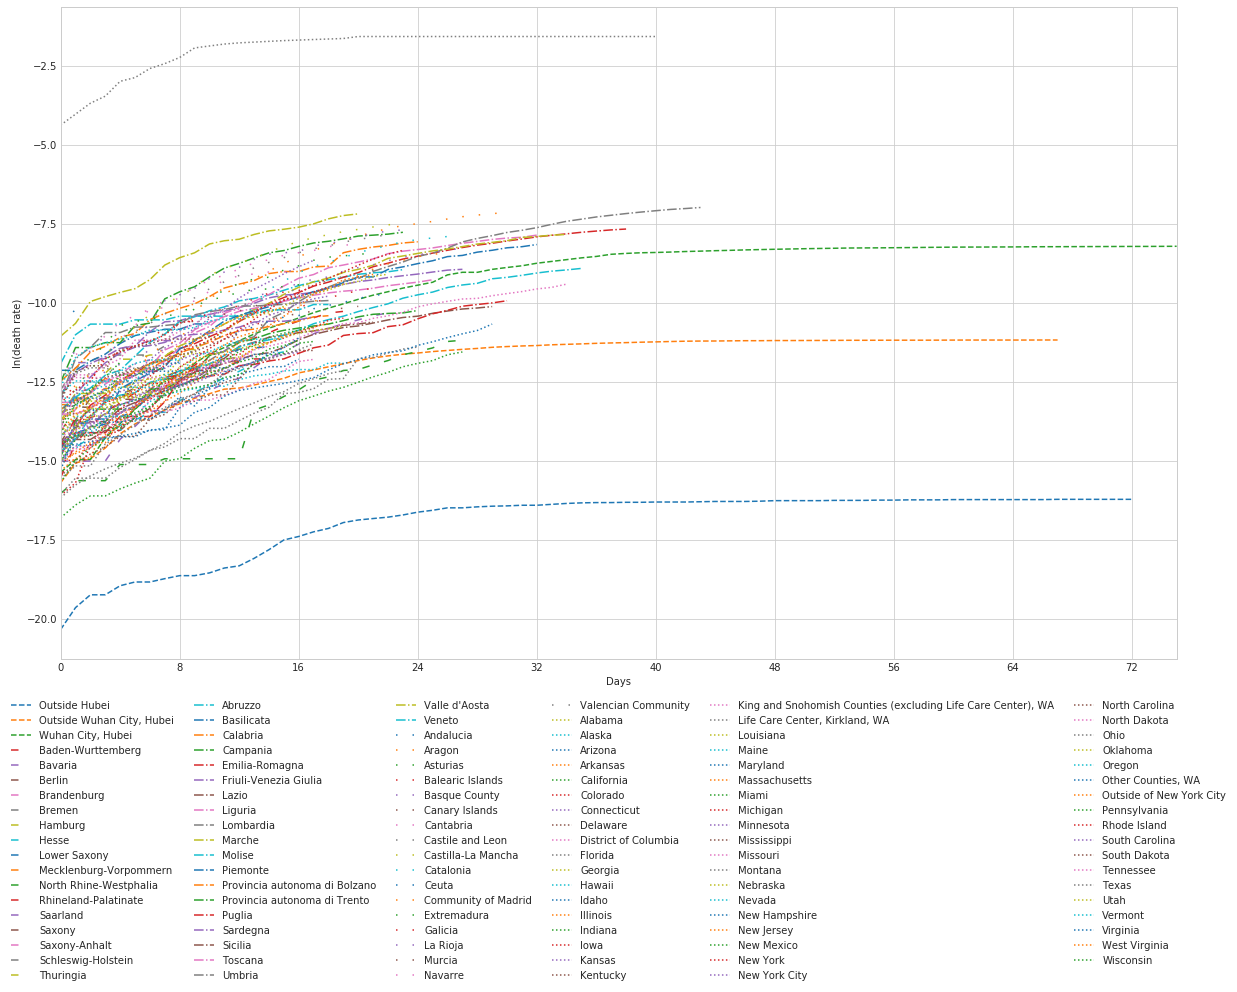

In [4]:
# come up with more informative names...
input_full_df = get_input_data('full_data', DATA_VERSION)
input_death_df = get_input_data('deaths', DATA_VERSION)
# # Dropping recent Montana data due to slow growth resulting in implausible backcast
# input_death_df = input_death_df.loc[(input_death_df['Location']!="Montana") | (input_death_df['Date'] < pd.Timestamp("2020-04-01"))]
input_age_pop_df = get_input_data('age_pop', DATA_VERSION)
input_age_death_df = get_input_data('age_death', DATA_VERSION)

# plot
plot_crude_rates(input_death_df, level='subnat')


## store pops for bobby

In [5]:
get_input_data('us_pops').to_csv(f'{OUTPUT_DIR}/pops.csv', index=False)


## combine back-casted death rates with cases for abie (using model dataset, i.e. admin1 and below)

In [6]:
#%%capture
location_ids = sorted(input_full_df.loc[(np.log(input_full_df['Death rate']) > RATE_THRESHOLD) &
                                  (~input_full_df['Province/State'].isnull()), 
                                  'location_id'].unique())
location_ids = [60408, 60410,60411, 532, 555]

start_time = datetime.now()
def combine_cases_w_backcast_deaths(location_id):
    mod_df = DeathModelData(input_death_df, input_age_pop_df, input_age_death_df, location_id, 'threshold', subnat=True, rate_threshold=RATE_THRESHOLD).df
    mod_df = mod_df.loc[mod_df['location_id'] == location_id].reset_index(drop=True)
    if len(mod_df) > 0:
        date0 = mod_df['Date'].min()
        day0 = mod_df.loc[~mod_df['Date'].isnull(), 'Days'].min()
        mod_df.loc[mod_df['Days'] == 0, 'Date'] = date0 - timedelta(days=np.round(day0))
        mod_df = mod_df.loc[~((mod_df['Deaths'].isnull()) & (mod_df['Date'] == date0))]
        mod_df = mod_df.loc[~mod_df['Date'].isnull()]
        mod_df.loc[mod_df['Death rate'].isnull(), 'Death rate'] = np.exp(mod_df['ln(age-standardized death rate)'])
        mod_df.loc[mod_df['Deaths'].isnull(), 'Deaths'] = mod_df['Death rate'] * mod_df['population']
        mod_df = mod_df.rename(index=str, columns={'Location':'Province/State'})
    else:
        mod_df = pd.DataFrame(
            columns=['location_id', 'Province/State', 'Country/Region', 'Date', 'Deaths', 'Death rate', 'population']
        )

    return mod_df[['location_id', 'Province/State', 'Country/Region', 'Date', 'Deaths', 'Death rate', 'population']].reset_index(drop=True)

loc_dfs = [combine_cases_w_backcast_deaths(location_id) for location_id in location_ids]
loc_df = pd.concat(loc_dfs)
loc_df = input_full_df[['location_id', 'Province/State', 'Country/Region', 'Date', 'Confirmed', 'Confirmed case rate']].merge(loc_df, how='outer')
loc_df['location_id'] = loc_df['location_id'].astype(int)
loc_df.to_csv(f'{OUTPUT_DIR}/backcast_for_case_to_death.csv', index=False)
date_df = impute_death_threshold(loc_df,
                                 location_list=loc_df.loc[(loc_df['Country/Region'] == 'United States of America') &
                                                          (~loc_df['Province/State'].isnull()), 'Province/State'].unique().tolist(),
                                 ln_death_rate_threshold=RATE_THRESHOLD)
date_df.to_csv(f'{OUTPUT_DIR}/threshold_dates.csv', index=False)
del loc_df  # , last_day_state_df
end_time = datetime.now()


Only using admin1 and below locations
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 60408
Fix backcasting if we change nursing home observations (drop by name).
Only using admin1 and below locations
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 60410
Fix backcasting if we change nursing home observations (drop by name).
Only using admin1 and below locations
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 60411
Fix backcasting if we change nursing home observations (drop by name).
Only using admin1 and below locations
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 532


ValueError: No objects to concatenate

In [6]:
print(f'{OUTPUT_DIR}/threshold_dates.csv')
print(end_time - start_time)


/ihme/covid-19/deaths/dev/2020_04_06_cities/threshold_dates.csv
0:00:53.219721


## create datasets for each subnational unit of US

In [7]:
# get location information
loc_df = get_location_metadata(location_set_id=35, gbd_round_id=6)
location_ids = loc_df.loc[(loc_df['parent_id'] == 102) & (loc_df['location_name'] != 'Washington'), 
                          'location_id'].to_list()
location_names = loc_df.loc[(loc_df['parent_id'] == 102) & (loc_df['location_name'] != 'Washington'), 
                           'location_name'].to_list()
for wa_location in ['Other Counties, WA',
                    'King and Snohomish Counties (excluding Life Care Center), WA', 
                    'Life Care Center, Kirkland, WA']:
    location_ids += [input_full_df.loc[input_full_df['Province/State'] == wa_location, 'location_id'].unique().item()]
    location_names += [wa_location]

location_ids = [60408, 60410,60411, 532, 555]
location_names = ["Miami", "New York City", "Outside of New York City", "Florida", "New York"]

    
## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
## NEED TO ADD OPTION TO ADD NEW YORK + MIAMI (UNTIL WE MOVE TO LOCATION HIERARCHY)
## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

# method for getting dates
def date_mean(dates):
    dt_min = dates.min()
    deltas = [x-dt_min for x in dates]

    return dt_min + functools.reduce(operator.add, deltas) / len(deltas)

# get mean data from dataset
date_draws = [i for i in date_df.columns if i.startswith('death_date_draw_')]
date_mean_df = date_df.copy()
date_mean_df['threshold_date'] = date_mean_df.apply(
    lambda x: datetime.strptime(date_mean(x[date_draws]).strftime('%Y-%m-%d'), '%Y-%m-%d'),
    axis=1
)
date_mean_df['Country/Region'] = 'United States of America'
date_mean_df = date_mean_df.rename(index=str, columns={'location':'Location'})
date_mean_df = date_mean_df[['Location', 'Country/Region', 'threshold_date']]

# set up ensemble
model_out_dirs = []
for cov_sort, weights in COV_SETTINGS:
    for k in KS:
        # set up dirs
        model_out_dir = f'{OUTPUT_DIR}/model_data_{cov_sort}_{k}'
        if not os.path.exists(model_out_dir):
            os.mkdir(model_out_dir)
        model_out_dirs.append(model_out_dir)
            
# how many draws from each scenario
n_scenarios = len(COV_SETTINGS) * len(KS)
n_draws = [int(1000 / n_scenarios)] * n_scenarios
n_draws[-1] = n_draws[-1] + 1000 - np.sum(n_draws)

# submit models
N = len(location_ids)
i = 0
nursing_home_locations = ['Life Care Center, Kirkland, WA']
for location_id, location_name in zip(location_ids, location_names):
    i += 1
    print(f'{i} / {N} locations')
    mod = DeathModelData(input_death_df, input_age_pop_df, input_age_death_df, location_id, 'threshold', subnat=True, rate_threshold=RATE_THRESHOLD)
    if location_name in nursing_home_locations:
        # save only nursing homes
        mod_df = mod.df.copy()
    else:
        # save only others
        mod_df = mod.df.loc[~mod.df['Location'].isin(nursing_home_locations)].reset_index(drop=True)
    mod_df = mod_df.loc[~(mod_df['Deaths'].isnull())].reset_index(drop=True)
    n_i = 0
    for cov_sort, weights in COV_SETTINGS:
        for k in KS:
            # drop back-cast for modeling file, but NOT for the social distancing covariate step
            model_out_dir = f'{OUTPUT_DIR}/model_data_{cov_sort}_{k}'
            mod_df.to_csv(f'{model_out_dir}/{location_name}.csv', index=False)
            sd_cov = SocialDistCov(mod_df, date_mean_df)
            sd_cov_df = sd_cov.get_cov_df(weights=weights, k=k)
            sd_cov_df.to_csv(f'{model_out_dir}/{location_name} covariate.csv', index=False)
            if not os.path.exists(f'{model_out_dir}/{location_name}'):
                os.mkdir(f'{model_out_dir}/{location_name}')
            submit_curvefit(job_name=f'curve_model_{location_id}_{cov_sort}_{k}',
                            location_id=location_id, 
                            code_dir=CODE_DIR,
                            env=ENV,
                            model_location=location_name,
                            model_location_id=location_id,
                            data_file=f'{model_out_dir}/{location_name}.csv', 
                            cov_file=f'{model_out_dir}/{location_name} covariate.csv', 
                            output_dir=f'{model_out_dir}/{location_name}',
                            n_draws=n_draws[n_i])
            n_i += 1


1 / 3 locations
Only using admin1 and below locations
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 60408
Fix backcasting if we change nursing home observations (drop by name).
Your job 37506759 ("curve_model_60408_equal_21") has been submitted

Your job 37506760 ("curve_model_60408_ascmid_21") has been submitted

Your job 37506761 ("curve_model_60408_ascmax_21") has been submitted

2 / 3 locations
Only using admin1 and below locations
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 60410
Fix backcasting if we change nursing home observations (drop by name).
Your job 37506763 ("curve_model_60410_equal_21") has been submitted

Your job 37506766 ("curve_model_60410_ascmid_21") has been submitted

Your job 37506768 ("curve_model_60410_ascmax_21") has been submitted

3 / 3 locations
Only using admin1 and below locations
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of

## compile draws

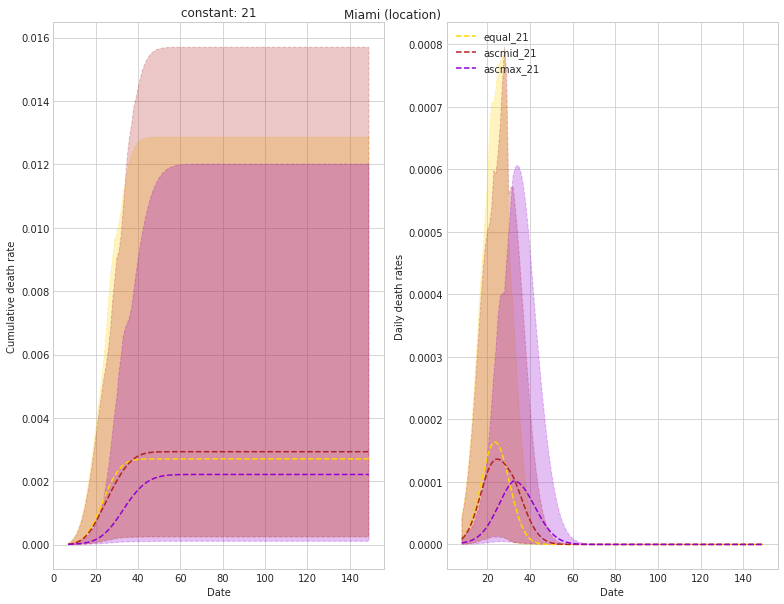

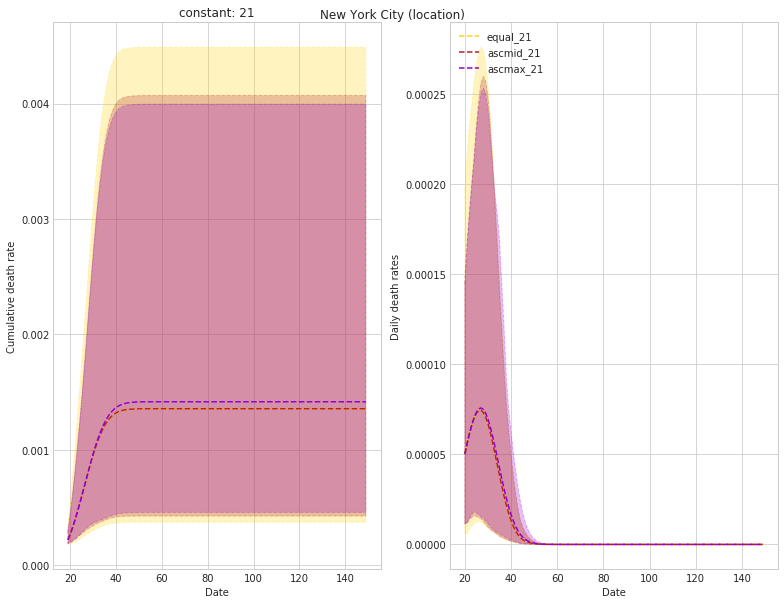

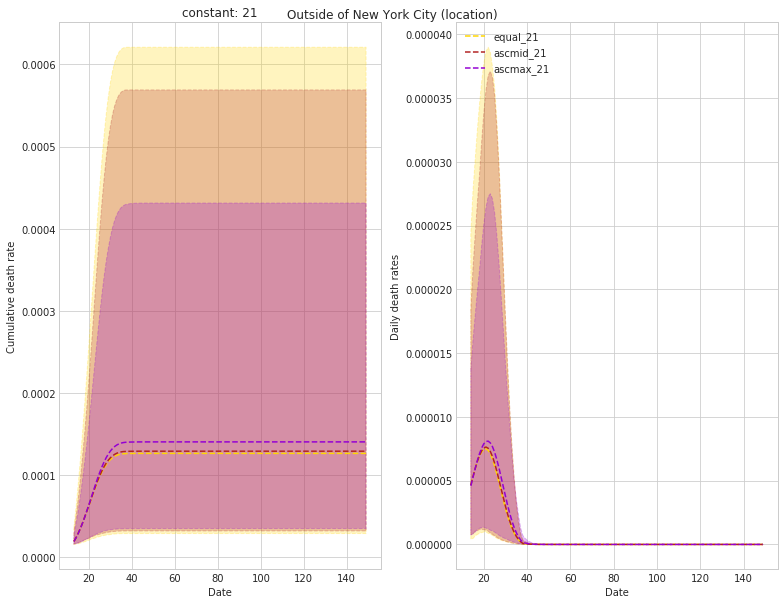

In [8]:
# subset US
usa_obs_df = input_full_df[(input_full_df['Country/Region'] == 'United States of America') & 
                           (~input_full_df['Province/State'].isnull()) & 
                           (input_full_df['Deaths'] > 0)]

# combine everything
draw_dfs = []
models_used = []
with PdfPages(f'{OUTPUT_DIR}/ensemble_plot.pdf') as pdf:
    for location_id, location_name in zip(location_ids, location_names):
        # get draws
        data_draws = Drawer(
            ensemble_dirs=model_out_dirs,
            location_name=location_name, 
            location_id=location_id, 
            obs_df=usa_obs_df.loc[usa_obs_df['Province/State'] == location_name],
            date_draws=date_df.loc[date_df['location'] == location_name, date_draws].values, 
            population=input_age_pop_df.loc[input_age_pop_df['location_id'] == location_id, 'population'].sum()
        )
        draw_df, model_used, days, ensemble_draws = data_draws.get_dated_draws()
        draw_dfs.append(draw_df)
        models_used.append(model_used)

        # plot ensemble
        fig, ax = plt.subplots(1, 2, figsize=(11, 8.5))
        for label, draws in ensemble_draws.items():
            label = label.split('model_data_')[1]
            draws = np.exp(draws)
            deaths_mean = draws.mean(axis=0)
            deaths_lower = np.percentile(draws, 2.5, axis=0)
            deaths_upper = np.percentile(draws, 97.5, axis=0)

            d_deaths_mean = (draws[:,1:] - draws[:,:-1]).mean(axis=0)
            d_deaths_lower = np.percentile(draws[:,1:] - draws[:,:-1], 2.5, axis=0)
            d_deaths_upper = np.percentile(draws[:,1:] - draws[:,:-1], 97.5, axis=0)

            # cumulative
            ax[0].fill_between(days,
                               deaths_lower, deaths_upper,
                               color=COLOR_DICT[label.split('_')[0]], 
                               linestyle=LINE_DICT[label.split('_')[1]], 
                               alpha=0.25)
            ax[0].plot(days, deaths_mean, 
                       c=COLOR_DICT[label.split('_')[0]], 
                       linestyle=LINE_DICT[label.split('_')[1]], )
            ax[0].set_title(f'constant: {k}')
            ax[0].set_xlabel('Date')
            ax[0].set_ylabel('Cumulative death rate')

            # daily
            ax[1].fill_between(days[1:],
                               d_deaths_lower, d_deaths_upper,
                               color=COLOR_DICT[label.split('_')[0]], 
                               linestyle=LINE_DICT[label.split('_')[1]], 
                               alpha=0.25)
            ax[1].plot(days[1:], d_deaths_mean, 
                       c=COLOR_DICT[label.split('_')[0]], 
                       linestyle=LINE_DICT[label.split('_')[1]], 
                       label=label.replace('model_data_', ''))
            ax[1].set_xlabel('Date')
            ax[1].set_ylabel('Daily death rates')

        ax[1].legend(loc=2)
        plt.suptitle(f'{location_name} ({model_used})')
        plt.tight_layout()
        pdf.savefig()
if 'location' not in models_used:
    raise ValueError('No location-specific draws used, must be using wrong tag')
draw_df = pd.concat(draw_dfs)
model_type_df = pd.DataFrame({
    'location':location_names,
    'model_used':models_used
})

# write
draw_df.to_csv(f'{OUTPUT_DIR}/state_data.csv', index=False)
model_type_df.to_csv(f'{OUTPUT_DIR}/state_models_used.csv', index=False)


## combine with previous predictions

In [9]:
avg_df = moving_average_predictions('US')
avg_df.to_csv(f'{OUTPUT_DIR}/past_avg_state_data.csv', index=False)
print(f'{OUTPUT_DIR}/past_avg_state_data.csv')


Averaging over the following files:  ['/ihme/covid-19/deaths/prod/2020_04_05_US/state_data.csv', '/ihme/covid-19/deaths/prod/2020_04_04_US/state_data.csv', '/ihme/covid-19/deaths/prod/2020_04_02_US/state_data.csv']


FileNotFoundError: [Errno 2] File /ihme/covid-19/deaths/prod/2020_04_06_US/state_data.csv does not exist: '/ihme/covid-19/deaths/prod/2020_04_06_US/state_data.csv'

In [ ]:
plotter = CompareModelDeaths(
    old_draw_path='/ihme/covid-19/deaths/prod/2020_04_05_US/state_data.csv',
    new_draw_path=f'{OUTPUT_DIR}/state_data.csv'
)
plotter.make_some_pictures(f'{OUTPUT_DIR}/compare_to_previous.pdf',
                           'United States of America')
